In [731]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils as ut

momo = [0.9, 0.95, 0.975, 0.99, 0.995, 0.9975, 0.999]
#momo = [0.975, 0.9975 , 0.9995]
nrec=5

print(*momo)
gamma = 1

Igamma = 6

true_gamma = 1 - ( 1 - momo[Igamma]) / nrec
p_filling = 0.5
giver_reward = -0.5
consume=0.0
# Model of the ant colony
system_name = 'ant_cons_exchanges'
# Name of the specific run with the current parmeters
run_name = 'NOCONSUME_'+str(nrec+1)+'p_gamma_eq'+str(momo[Igamma])+'_pFilling'+str(p_filling)+'_giverR'+str(giver_reward)+'_REDO'
print(run_name)
data_dir = 'data/' + system_name + '/' + run_name + '/'
print(data_dir)

0.9 0.95 0.975 0.99 0.995 0.9975 0.999
NOCONSUME_6p_gamma_eq0.999_pFilling0.5_giverR-0.5_REDO
data/ant_cons_exchanges/NOCONSUME_6p_gamma_eq0.999_pFilling0.5_giverR-0.5_REDO/


## Environment

### General parameters

In [732]:
env_params = dict()

# Size of the belly of each ant
env_params['max_k'] = 19
# Number of recipient in the colony
env_params['n_recipients'] = nrec
# Probability of a succesfull gathering
env_params['p_succ'] = 0.1

if system_name in ['ant_cons', 'ant_cons2', 'ant_cons2_fast', 'ant_cons2_death', 'ant_cons2_stress', 'ant_cons_exchanges', 'ant_cons_exchanges_choice'] :
    # Probability that the food of a recipient decreases
    env_params['p_consume'] = consume
if system_name in ['ant_cons2', 'ant_cons_exchanges','ant_cons_exchanges_choice']:
    # Probability that the food of a recipient decreases
    env_params['p_filling'] = p_filling
    env_params['unif_filling'] = 'false'

if system_name ==  'ant_cons_exchanges' or system_name ==  'ant_cons_exchanges_choice' :
    env_params['true_gamma'] = true_gamma
    env_params['stop_by_discount'] = 'false'
    env_params['giver_reward'] = giver_reward
    env_params['only_forager'] = 'true'
    
if system_name == 'ant_cons2_death':
    # Penalty for death
    env_params['pen_death'] = 1
    env_params['rew_eat'] = 1
    env_params['true_gamma'] = 0.99333
    env_params['reward_life'] = 'false'
if system_name == 'ant_cons2_stress':
    # Penalty for stress
    env_params['pen_stress'] = 0.1
    env_params['reward_life'] = 'false'
    env_params['rew_eat'] = 1

### Initial condition

In [733]:
# Number between 1-max_k for a deterministic initialization of the ant food
# Number greater than max_k for a random initialization
#env_params['init_k'] = [env_params['max_k'] for _ in range(env_params['n_recipients']+1)]
env_params['init_k'] = [env_params['max_k']+1 for _ in range(env_params['n_recipients']+1)]
env_params['init_k'][0] = env_params['max_k']+1
#env_params['init_k'] = [3 for _ in range(env_params['n_recipients']+1)]

## Algorithm

### Algorithm type

In [734]:
alg_params = dict()
alg_params['alg_type'] = 'nac_et'
alg_params['gamma'] = gamma
alg_params['stop_by_discount'] = 'false'
alg_params['lambda_actor'] = true_gamma
alg_params['lambda_critic'] = true_gamma
alg_params['continuous_task'] = 'false'
alg_params['lr_rew_factor'] = 0.00
alg_params['simplex_clipping'] = 'true'
alg_params['simplex_clipping_epsilon'] = 0.001

# TIME
alg_params['n_steps'] = 5000000 # Number of training steps
alg_params['traj_points'] = 500

# EVALUATION
alg_params['eval_steps'] = 10 # Number of evaluation steps at the end of the training

### General parameters

In [735]:
# CRITIC LEARNING RATE
alg_params['a0'] = 0.025
alg_params['ac'] = alg_params['n_steps']/300
alg_params['a_expn'] = 0.85
alg_params['a_burn'] = alg_params['n_steps']*0.7
# List of multiplicative factors for the actor learnig rates for each player
alg_params['a_lr_factor'] = np.ones(env_params['n_recipients']+1)
alg_params['a_lr_factor'][0] = 1 #/env_params['n_recipients']



# ACTOR LEARNING RATE
alg_params['b0'] = 0.000
alg_params['bc'] = alg_params['n_steps'] / 300
alg_params['b_expn'] = 0.85
alg_params['b_burn'] = alg_params['n_steps']*0.7
# List of multiplicative factors for the actor learnig rates for each player
alg_params['b_lr_factor'] = np.ones(env_params['n_recipients']+1)
alg_params['b_lr_factor'][0] = 1 #/env_params['n_recipients']

<ipython-input-736-982a568f923c>:2: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.tight_layout()


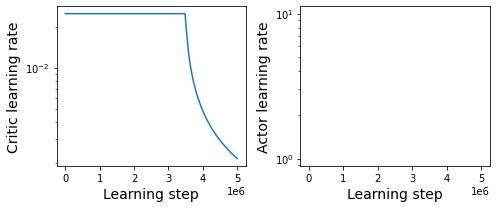

In [736]:
fig, (ax1, ax2) = ut.plot_lr(alg_params)
plt.tight_layout()

### Init condition of the learning

In [737]:
# INITIAL CONDITIONS
# Comment 'init_q_path' for a flat policy
alg_params['init_values'] = 35
#alg_params['init_values_rand'] = 150
#alg_params['init_val_path'] = data_dir + "/best_value.txt"


In [738]:
#alg_params['init_val_path'] = data_dir + '/init_val.txt' 
#forag_val = 25
#vals = np.ones((env_params['n_recipients']+1, 2*(1+env_params['max_k'])))*rec_val
#vals[0]*=forag_val/rec_val
#np.savetxt(data_dir + '/init_val.txt', vals, delimiter='\t')

## Wtriting the parameters in data_dir

In [739]:
ut.write_params(env_params, data_dir, "param_env.txt")
ut.write_params(alg_params, data_dir, "param_alg.txt")

## Set init policy

In [740]:


def policy_1_above(k):
    pol = []
    for i in range((env_params['max_k']+1)*2):
        if i<env_params['max_k']+1:
            if i<=k:
                pol.append([1,0])
            else:
                pol.append([0,1])
        else:
            pol.append([1])
    return pol

def policy_1_at(indexes):
    pol = []
    for i in range((env_params['max_k']+1)*2):
        if i<env_params['max_k']+1:
            if i not in indexes:
                pol.append([1,0])
            else:
                pol.append([0,1])
        else:
            pol.append([1])
    return pol

def rand_policy():
    pol = []
    for i in range((env_params['max_k']+1)*2):
        if i<env_params['max_k']+1:
            pol.append([0.5,0.5])
        else:
            pol.append([1])
    return pol

def rand_policy_f():
    pol = []
    for i in range((env_params['max_k']+1)*4):
        if i<env_params['max_k']+1:
            pol.append([0.5,0.5])
        else:
            pol.append([1])
    return pol

def empirical_policy_f_int(L):
    pol = []
    for i in range((env_params['max_k']+1)*4):
        if i<env_params['max_k']+1:
            if i<L:
                pol.append([1.0, 0.0])
            else:
                pol.append([0.0, 1.])
        else:
            pol.append([1])
    return pol

def empirical_policy_r_int(L, epsilon):
    pol = []
    for i in range((env_params['max_k']+1)*4):
        if i<env_params['max_k']+1:
            if i<L:
                pol.append([1.0, 0.0])
            else:
                pol.append([0.0, 1.0])
        elif ((i>=env_params['max_k']*1+1) and (i<env_params['max_k']*2+2)):        
            pol.append([np.power(epsilon,1./L), 1-np.power(epsilon,1./L)])
        else:
            pol.append([1])
    return pol

def empirical_policy_r_noexch(L, epsilon):
    pol = []
    for i in range((env_params['max_k']+1)*4):
        if i<env_params['max_k']+1:
            pol.append([1.0, 0.0])
        elif ((i>=env_params['max_k']*1+1) and (i<env_params['max_k']*2+2)):        
            pol.append([np.power(epsilon,1./L), 1-np.power(epsilon,1./L)])
        else:
            pol.append([1])
    return pol

def random_policy_r_noexch():
    pol = []
    for i in range((env_params['max_k']+1)*4):
        if i<env_params['max_k']+1:
            pol.append([1.0, 0.0])
        elif ((i>=env_params['max_k']*1+1) and (i<env_params['max_k']*2+2)):        
            pol.append([0.5, 0.5])
        else:
            pol.append([1])
    return pol

def rand_policy_r():
    pol = []
    for i in range((env_params['max_k']+1)*4):
        if i<env_params['max_k']*2+2:
            pol.append([0.5,0.5])
        else:
            pol.append([1])
    return pol

def rand_policy_f_proposed():
    pol = []
    for i in range((env_params['max_k']+1)*4):
        if i<env_params['max_k']+1:
            prop = [0.5/(nrec) for i in range(nrec+1)]
            prop[0] = 0.5
            pol.append(prop)
        else:
            pol.append([1])
    return pol


def empirical_policy_f_proposed():
    pol = []
    for i in range((env_params['max_k']+1)*4):
        if i<env_params['max_k']+1:
            if i>=10:
                prop = [1/(nrec) + (np.random.rand()-0.5)*0. for i in range(nrec+1)]
                prop[0] = 0.0
            else:
                prop = [0 for i in range(nrec+1)]
                prop[0] = 1.0
            pol.append(prop)
        else:
            pol.append([1])
    return pol


def rand_policy_r_proposed(ID):
    pol = []
    for i in range((env_params['max_k']+1)*4):
        if i<env_params['max_k']+1:
            prop = [0.5/(nrec-1) for i in range(nrec)]
            prop[ID] = 0.5
            pol.append(prop)
        elif ((i>=env_params['max_k']*1+1) and (i<env_params['max_k']*2+2)):
            pol.append([0.5, 0.5])
        else:
            pol.append([1])
    return pol

def empirical_policy_r_proposed(ID, L, epsilon):
    pol = []
    ran = (np.random.rand()-0.5)*0.3
    for i in range((env_params['max_k']+1)*4):
        if i<env_params['max_k']+1:
            if i>=10:
                prop = [1/(nrec) + (np.random.rand()-0.5)*0. for i in range(nrec+1)]
                prop[ID] = 0.0
            else:
                prop = [0 for i in range(nrec+1)]
                prop[ID] = 1.0
            pol.append(prop)
        elif ((i>=env_params['max_k']*1+1) and (i<env_params['max_k']*2+2)):
            pol.append([np.power(epsilon,1./L) + ran, 1-np.power(epsilon,1./L) - ran])
        else:
            pol.append([1])
    return pol


def empirical_policy_F(L):
    pol = []
    for i in range((env_params['max_k']+1)*2):
        if i<env_params['max_k']+1:
            if i<L:
                pol.append([1.0, 0.0])
            else:
                pol.append([0.0, 1.0])
        else:
            pol.append([1])
    return pol

def empirical_policy_R(L, epsilon):
    pol = []
    for i in range((env_params['max_k']+1)*2):
        if i<env_params['max_k']+1:
            pol.append([np.power(epsilon,1./L), 1-np.power(epsilon,1./L)])
        else:
            pol.append([1])
    return pol

def greedy_policy_F():
    pol = []
    for i in range((env_params['max_k']+1)*2):
        if i<env_params['max_k']+1:
            pol.append([0.0, 1.0])
        else:
            pol.append([1])
    return pol

def greedy_policy_R():
    pol = []
    for i in range((env_params['max_k']+1)*2):
        if i<env_params['max_k']+1:
            pol.append([1.0, 0.0])
        else:
            pol.append([1])
    return pol

In [741]:
policies = []
for_pol = []
# Forager
#policies.append(policy_1_above(8))

L = 10
epsilon = 0.001

#policies.append(empirical_policy_F(L))
#policies.append(empirical_policy_f_proposed())
#policies.append(greedy_policy_F())
policies.append(rand_policy_f())
#policies.append(empirical_policy_f_int(14))

# Recipients
for p in range(env_params['n_recipients']):
    #policies.append(policy_1_above(8))
    #policies.append(policy_1_at([8]))
    #policies.append(rand_policy_r())
    #policies.append(empirical_policy_R(L, epsilon))
    #policies.append(empirical_policy_r_proposed(p, 10, 0.01))
    #policies.append(empirical_policy_r_noexch(L, epsilon))
    policies.append(random_policy_r_noexch())
    #policies.append(greedy_policy_R())


### Writing external files

In [742]:
for p in range(env_params['n_recipients']+1):
    f = open(data_dir+'init_pol'+str(p)+'.txt', "w")
    for l in policies[p]:
        s = ''
        for elem in l:
            s+=str(elem)
            s+='\t'
        f.write(s+'\n')
    f.close()

In [743]:
alg_params['init_pol_dir'] = data_dir
#alg_params['init_pol_dir'] = 'data/' + system_name + '/2p_long_gamma1/' 
ut.write_params(env_params, data_dir, "param_env.txt")
ut.write_params(alg_params, data_dir, "param_alg.txt")